Data Science
================================
Multiple Linear Regression
--------------------------------
Alessandro D. Gagliardi

Last Time
---------

* What is a regression model?
* History of Probability
* Descriptive statistics -- numerical
* Descriptive statistics -- graphical
* p-values and Hypothesis Testing
* Inference about a population mean
* Difference between two population means

Agenda
---------
* [Visualizing distributions of data](#Visualizing-distributions-of-data)
* [Linear Models](#Linear-Models)
* [Ordinary Least Squares](#Ordinary-Least-Squares)
* [Multiple Regression](#Multiple-Regression)
* [Inference for Multiple Regression](#Inference-for-multiple-regression)

# Visualizing distributions of data

<small>The following is adapted from http://stanford.edu/~mwaskom/software/seaborn/tutorial/plotting_distributions.html</small>

This notebook demonstrates different approaches to graphically
representing distributions of data, specifically focusing on the tools
provided by the [seaborn](https://github.com/mwaskom/seaborn) package.

In [1]:
%matplotlib inline

In [2]:
from __future__ import division

import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

from numpy.random import randn
from scipy import stats
from seaborn import plt
from statsmodels.stats.anova import anova_lm

In [3]:
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})
np.random.seed(9221999)

Basic visualization with histograms
-----------------------------------


The most basic and common way of representing a distributions is with a
histogram. We can do this directly through the ``hist`` function that is
part of matplotlib.

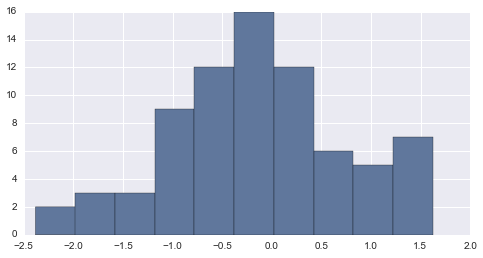

In [4]:
data = randn(75)
plt.hist(data);

By default, ``hist`` separates the data into 10 bins of equal widths and
plots the number of observations in each bin. Thus, the main parameter
is the number of bins, which we can change.

The more bins you have, the more sensitive you will be to high-frequency
patterns in the distribution. But, sometimes those high-frequency
patterns will be noise. Often you want to try different values until you
think you have best captured what you see in the data.

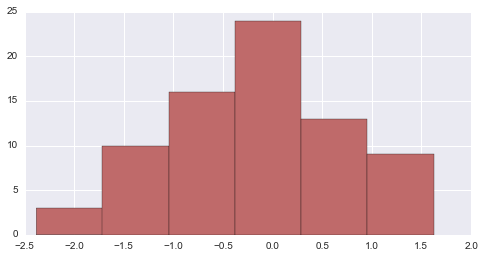

In [5]:
plt.hist(data, 6, color=sns.desaturate("indianred", .75));

Estimating the density of the observations: ``kdeplot`` and ``rugplot``
-----------------------------------------------------------------------


A superior, if more computationally intensive, approach to estimating a
distribution is known as a kernel density estimate, or KDE. To motivate
the KDE, let's first think about rug plots. A rug plot is a very simple,
but also perfectly legitimate, way of representing a distribution. To
create one, simply draw a vertical line at each observed data point.
Here, the height is totally arbitrary.

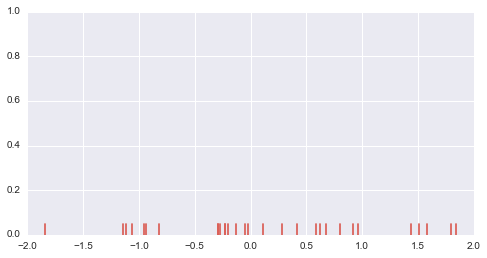

In [6]:
sns.set_palette("hls", 1)
data = randn(30)
sns.rugplot(data)
plt.ylim(0, 1);

You can see where the density of the distribution is by how dense the
tick-marks are. Before talking about kernel density plots, let's connect
the rug plot to the histogram. The connection here is very direct: a
histogram just creates bins along the range of the data and then draws a
bar with height equal to the number of ticks in each bin

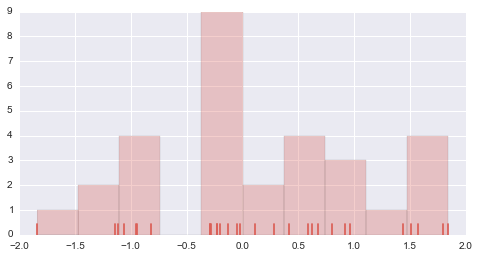

In [7]:
plt.hist(data, alpha=.3)
sns.rugplot(data);

A kernel density plot is also a transformation from the tick marks to a
height-encoded measure of density. However, the transformaiton is a bit
more complicated. Instead of binning each tick mark, we will instead
represent each tick with a gaussian basis function.

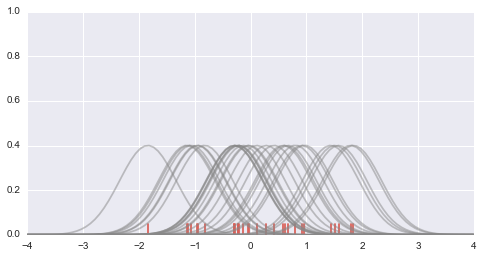

In [8]:
# Draw the rug and set up the x-axis space
sns.rugplot(data);
xx = np.linspace(-4, 4, 100)

# Compute the bandwidth of the kernel using a rule-of-thumb
bandwidth = ((4 * data.std() ** 5) / (3 * len(data))) ** .2
bandwidth = len(data) ** (-1. / 5)

# We'll save the basis functions for the next step
kernels = []

# Plot each basis function
for d in data:

    # Make the basis function as a gaussian PDF
    kernel = stats.norm(d, bandwidth).pdf(xx)
    kernels.append(kernel)

    # Scale for plotting
    kernel /= kernel.max()
    kernel *= .4
    plt.plot(xx, kernel, "#888888", alpha=.5)

plt.ylim(0, 1);

We then estimate the distribution that our samples came from from by
summing these basis functions (and normalizing so, as a proper density,
the function integrates to 1).

There is also a function in the ``scipy.stats`` module that will perform
a kernel density estimate (it actually returns an object that can be
called on some values to return the density). We see that plotting the
values from this object give us basically the same results as summing
the gaussian basis functions.

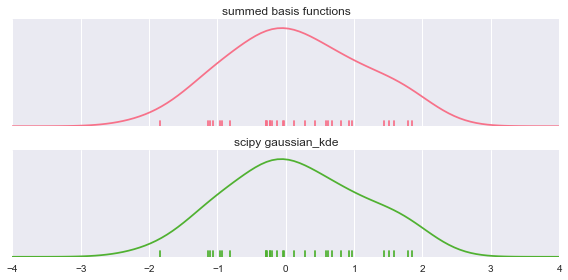

In [9]:
# Set up the plots
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
c1, c2 = sns.color_palette("husl", 3)[:2]

# Plot the summed basis functions
summed_kde = np.sum(kernels, axis=0)
ax1.plot(xx, summed_kde, c=c1)
sns.rugplot(data, c=c1, ax=ax1)
ax1.set_yticks([])
ax1.set_title("summed basis functions")

# Use scipy to get the density estimate
scipy_kde = stats.gaussian_kde(data)(xx)
ax2.plot(xx, scipy_kde, c=c2)
sns.rugplot(data, c=c2, ax=ax2)
ax2.set_yticks([])
ax2.set_title("scipy gaussian_kde")
f.tight_layout()

The seaborn package has a high-level function for plotting a kernel
density estimate in one quick step, along with some additional nice
features, such as shading in the density.

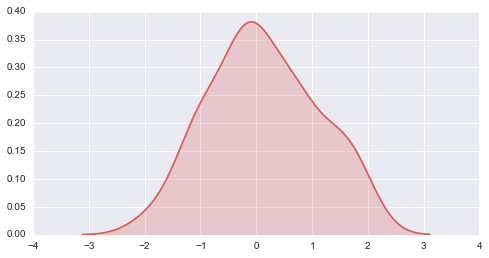

In [10]:
sns.kdeplot(data, shade=True);

Much like how the bins parameter controls the fit of the histogram to the data, you can adjust the bandwidth (bw) of the kernel to make the densisty estimate more or less sensitive to high-frequency structure.

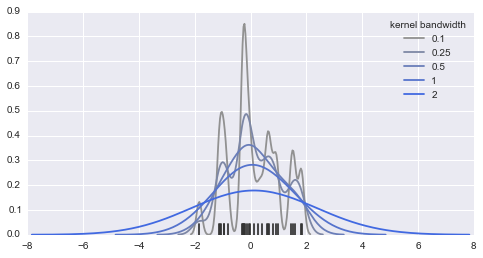

In [11]:
pal = sns.blend_palette([sns.desaturate("royalblue", 0), "royalblue"], 5)
bws = [.1, .25, .5, 1, 2]

for bw, c in zip(bws, pal):
    sns.kdeplot(data, bw=bw, color=c, lw=1.8, label=bw)

plt.legend(title="kernel bandwidth")
sns.rugplot(data, color="#333333");

You can also use ``kdeplot`` to estimate the cumulative distribution
function (CDF) of the population from your data. This plot will tell you
what proportion of the distribution falls at smaller values than a given
point on the ``x`` axis:

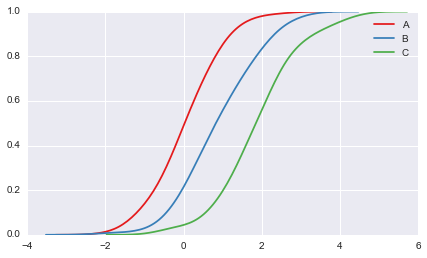

In [12]:
plt.figure(figsize=(7, 4))
data = stats.norm(0, 1).rvs((3, 100)) + np.arange(3)[:, None]

with sns.color_palette("Set1"):
    for d, label in zip(data, list("ABC")):
        sns.kdeplot(d, cumulative=True, label=label)

Combining plot styles: ``distplot``
-----------------------------------


Each of these styles has advantages and disadvantages. Fortunately, it
is easy to combine multiple styles using the ``distplot`` function in
seaborn. ``distplot`` provides one interface for plotting histograms,
kernel density plots, rug plots, and plotting fitted probability
distributions.

By default, you'll get a kernel density over a histogram. Unlike the
default matplotlib ``hist`` function, ``distplot`` tries to use a good
number of bins for the dataset you have, although all of the options for
specifying bins in ``hist`` can be used.


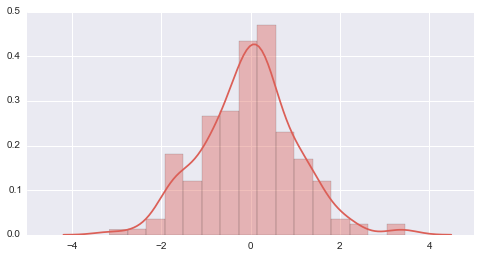

In [13]:
sns.set_palette("hls")
mpl.rc("figure", figsize=(8, 4))
data = randn(200)
sns.distplot(data);

``hist``, ``kde``, and ``rug`` are boolean arguments to turn those
features on and off.

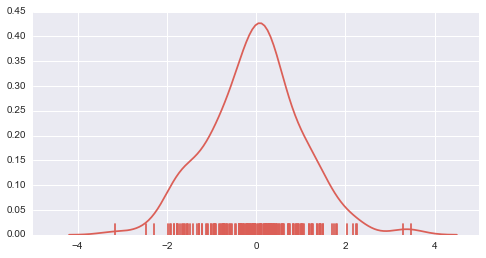

In [14]:
sns.distplot(data, rug=True, hist=False);

If the data has a ``name`` attribute (e.g. it is a pandas ``Series``),
the name will become the label for the dimension on which the
distribution is plotted, unless you use ``axlabel=False``. You can also
provide a string, which will override this behavior and label nameless
data.

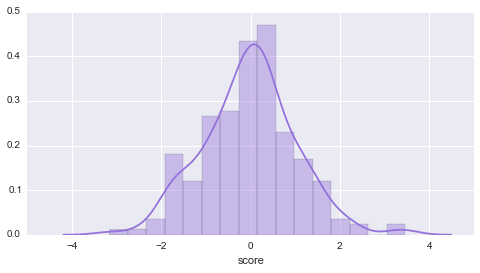

In [15]:
ser = pd.Series(data, name="score")
sns.distplot(ser, color="mediumpurple");

You can also pass a distribution family from ``scipy.stats``, and
``distplot`` will fit the parameters using maximum likelihood and plot
the resulting function.

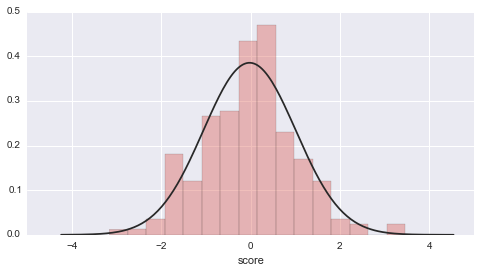

In [16]:
sns.distplot(ser, kde=False, fit=stats.norm);

# Linear Models

<img src="assets/machine_learning6.png" width="800" \>

Recall:
========================================================
A **regression** model is a functional relationship between input & response variables.

$$ y = \alpha + \beta x + \epsilon $$

$y =$ **response variable** (the one we want to predict)

$x =$ **input variable** (the one we use to train the model)

$\alpha =$ **intercept** (where the line crosses the y-axis)

$\beta =$ **regression coefficient** (the model "parameter")

$\epsilon =$ **residual** (the prediction error)

In [17]:
heights = pd.read_csv('data/heights.csv', index_col=0)
res = smf.ols("Dheight ~ Mheight", heights).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Dheight   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     435.5
Date:                Sun, 22 Mar 2015   Prob (F-statistic):           3.22e-84
Time:                        15:21:23   Log-Likelihood:                -3075.0
No. Observations:                1375   AIC:                             6154.
Df Residuals:                    1373   BIC:                             6164.
Df Model:                           1                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     29.9174      1.622     18.439      0.000        26.735    33.100
Mheight        0.5417      0.026     20.868      0.000         0.491     0.593
==============================================================================
Omnibus:                        1.412   Durbin-Watson:                   0.126
Prob(Omnibus):                  0.494   Jarque-Bera (JB):                1.353
Skew:                           0.002   Prob(JB):                        0.508
Kurtosis:                       3.154   Cond. No.                     1.66e+03
==============================================================================

Warnings:
[1] The condition number is large, 1.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### *Q: What's the $x$, $y$, $\alpha$, $\beta$, and $\epsilon$ in this case?*

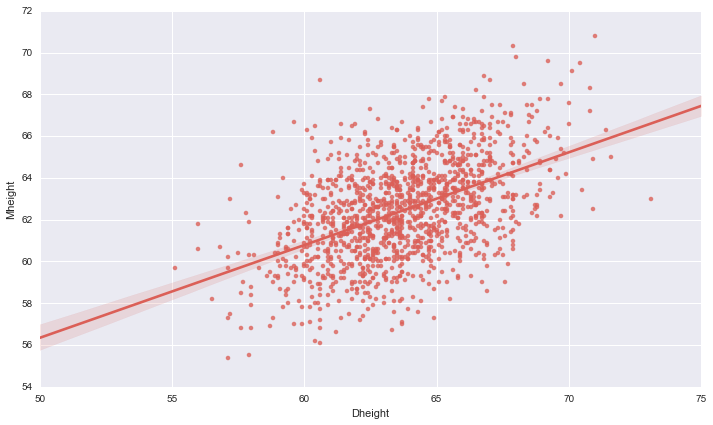

In [18]:
sns.lmplot("Dheight", "Mheight", heights, size=6, aspect=5/3);

This plot has two main components. The first is a scatterplot, showing the observed datapoints. The second is a regression line, showing the estimated linear model relating the two variables. Because the regression line is only an *estimate*, it is plotted with a 95% confidence band to give an impression of the certainty in the model. You can plot different levels of certainty. For instance, it is common to plot the *standard error* of an estimate, which corresponds to the 68% confidence interval.

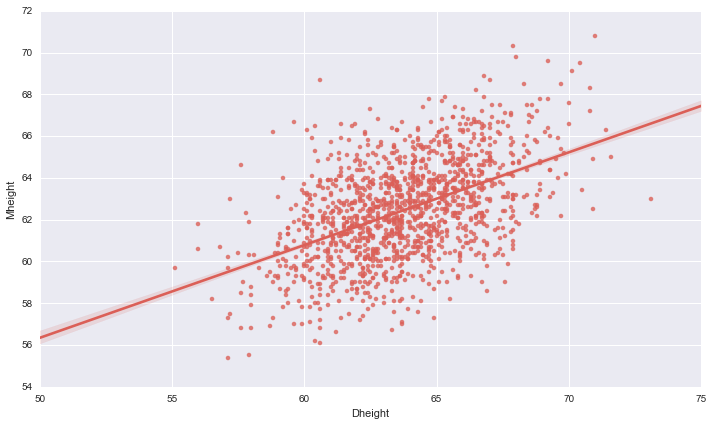

In [19]:
sns.lmplot("Dheight", "Mheight", heights, ci=68, size=6, aspect=5/3);

Hopefully, the default aesthetics are suitable for exploratory graphics. However, you  can also control the aesthetics of the underlying plots separately through dictionaries of keyword arguments for the matplotlib ``scatter`` and ``plot`` functions.

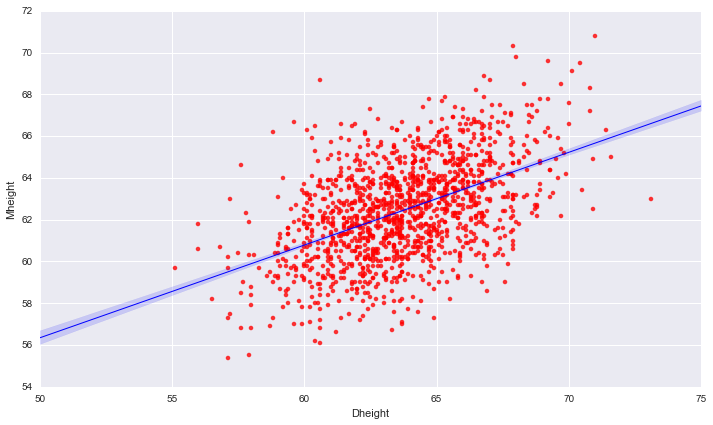

In [20]:
sns.lmplot("Dheight", "Mheight", heights, 
            scatter_kws={"marker": ".", "color": "red"},
            line_kws={"linewidth": 1, "color": "blue"},
            ci=68, size=6, aspect=5/3);

Plotting with discrete predictor variables
------------------------------------------

Sometimes you will want to plot data where the independent variable is quantitative, but discrete. Recall our RTW data. Although this works fine out of the box:

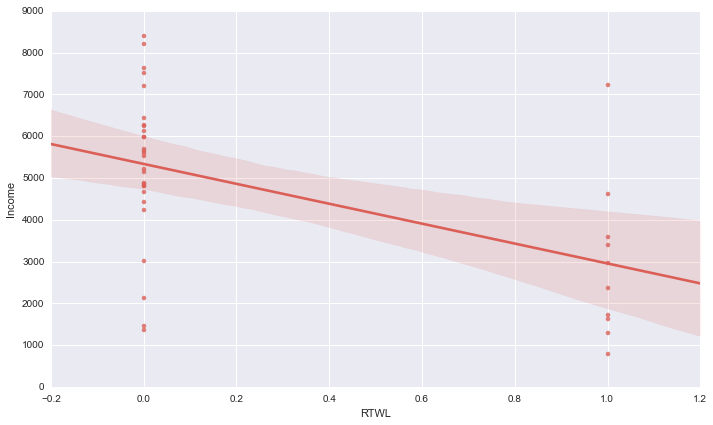

In [21]:
rtw = pd.read_table("data/P005.txt")
sns.lmplot("RTWL", "Income", rtw, size=6, aspect=5/3);

And can be improved with a bit of jitter:

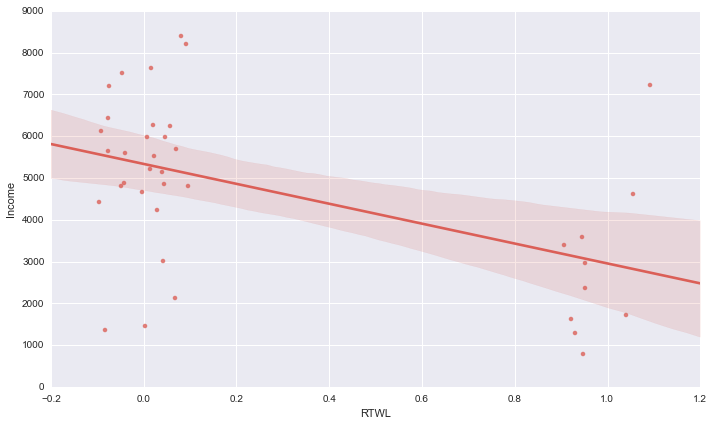

In [22]:
sns.lmplot("RTWL", "Income", rtw, x_jitter=.1, size=6, aspect=5/3);

It might be more informative to estimate the central tendency of each bin. This is easy to do with the x_estimator argument. Just pass any function that aggregates a vector of data into one estimate. The estimator will be bootstrapped and a confidence interval will be plotted -- 95% by default, as in other cases within these functions.

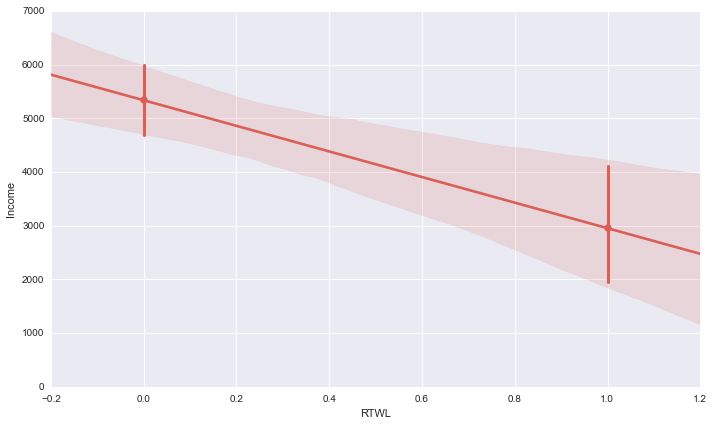

In [23]:
sns.lmplot("RTWL", "Income", rtw, x_estimator=np.mean, size=6, aspect=5/3);

### *Q: What is a confidence interval? What does a 95% c.i. mean in this context?*

It can also be useful to bin continuous predictor variable into discrete values and plot an estimated central tendency and confidence interval. This can be helpful when you have many datapoints and a reliable, but weak, effect. Note that the regression estimate will still fit to the original data; the binning only applies to the visual representation of the observations.

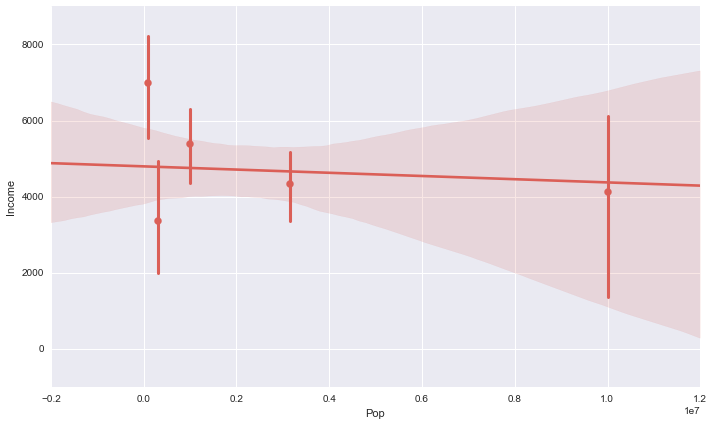

In [24]:
sns.lmplot("Pop", "Income", rtw, x_bins=np.logspace(5,7,5), size=6, aspect=5/3);

Or, you can give a number of bins and it will find centroids so that they have equal numbers of datapoints in them:

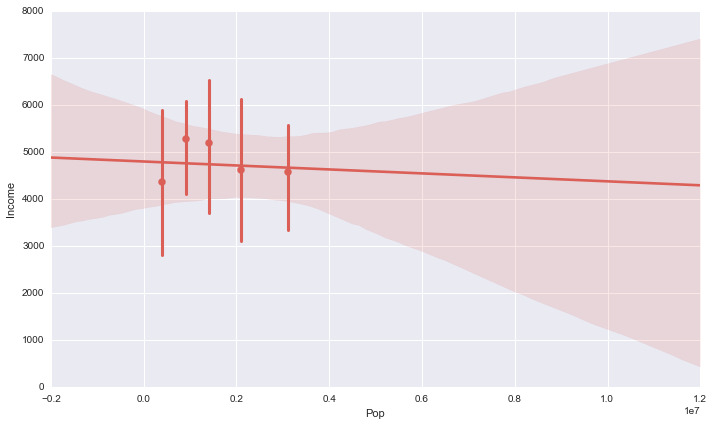

In [25]:
sns.lmplot("Pop", "Income", rtw, x_bins=5, size=6, aspect=5/3);

# Ordinary Least Squares

Q. How do we fit a regression model to a dataset?

A. Minimize the sum of the squared residuals (OLS)

$$ min(||y – \beta x||^2) $$

Aside
========================================================
Why least _squares_?

We want to penalize both positive and negative residuals.

But why squares and not, say, absolute values?

In fact, in the late 18th century, both of these were considered. OLS won because of procedures making it easier to compute by hand. Today, OLS dominates largely for historical reasons though it is also helpful as it allows a direct comparison between the square of the residuals and the square of the standard deviation (or variance) of the model. 

That said, minimizing absolute values may be prefered in cases where there are outliers. (Why?)

Polynomial Regression
========================================================
Consider the following **polynomial regression** model:
$$ y = \alpha + \beta_1 x + \beta_2 x^2 + \epsilon $$

Q:  This represents a nonlinear relationship. Is it still a linear model?

A:  Yes, because it’s linear in the $\beta$’s!

Polynomial Regression
========================================================
> Although *polynomial regression* fits a nonlinear model to the data, as statistical estimation problem it is linear, in the sense that the regression function $E(y|x)$ is linear in the unknown parameters that are estimated from the data. For this reason, polynomial regression is considered to be a special case of multiple linear regression.

(from [Wikipedia](http://en.wikipedia.org/wiki/Polynomial_regression))

Polynomial Regression
========================================================
Polynomial regression allows us to fit very complex curves to data.  
$$ y = \alpha + \beta_1 x + \beta_2 x^2 + \ldots + \beta_n x^n + \epsilon $$

However, it poses one problem, particularly in comparison to **simple linear regression**

What's the difference between simple linear regression and polynomial regression?

What's the problem that simple regression doesn't have?

Multicollinearity
========================================================
**Multicollinearity** is when predictor variables are highly correlated with each other

In [26]:
x = np.arange(1,10.1,0.1)
np.corrcoef(x**9, x**10)[0,1]

0.99876077218215631

This causes the model to break down because it can't tell the difference between predictor variables

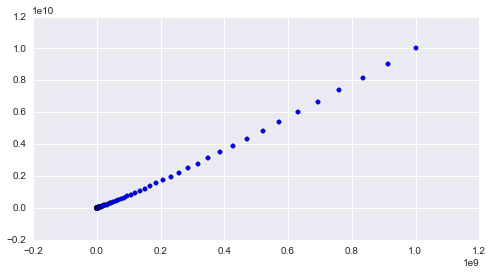

In [27]:
plt.scatter(x**9, x**10)

How we fix multicollinearity
========================================================
Replace the correlated predictors with uncorrelated predictors

$$ y = \alpha + \beta_1 f_1(x) + \beta_2 f_2(x^2) + \ldots + \beta_n f_n(x^n) + \epsilon $$

Technical Note: These polynomial functions form an _orthogonal basis_ of the function space.

We will revisit this when we talk about Principal Components Analysis.

# Multiple Regression

We can extend this model to several input variables, giving us the multiple linear regression model: 
<p style="text-align: center">$y = \alpha + \beta_1 x_1 + \ldots + \beta_n x_n + \epsilon$</p>

In [28]:
Description = ([
        ['Variable','Description'],
        ['lcavol', '(log) Cancer Volume'],
        ['lweight', '(log) Weight'],
        ['age', 'Patient age'],
        ['lbph', '(log) Vening Prostatic Hyperplasia'],
        ['svi', 'Seminal Vesicle Invasion'],
        ['lcp', '(log) Capsular Penetration'],
        ['gleason', 'Gleason score'],
        ['pgg45', 'Percent of Gleason score 4 or 5'],
        ['lpsa', '(log) Prostate Specific Antigen'],
        ['train', 'Label for test / training split']])

Prostate data
-------------
For more information on the [Gleason score](http://en.wikipedia.org/wiki/Gleason_Grading_System).

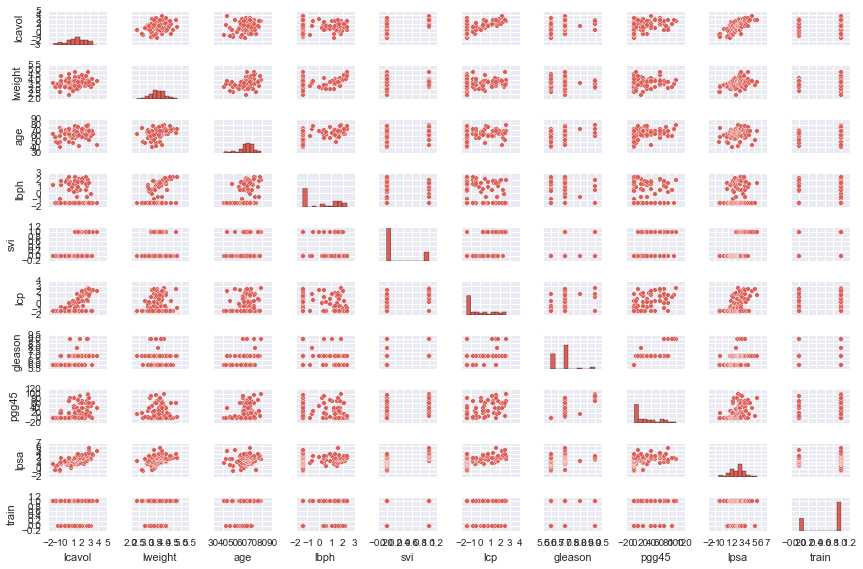

In [46]:
prostate = pd.read_csv('data/prostate.csv', index_col=0)
sns.pairplot(prostate[:-1], size=.8, aspect=1.5)

## Specifying the model

- We will use variables `lcavol, lweight, age, lbph, svi, lcp` and `pgg45`.

-   Rather than one predictor, we have $p=7$ predictors.

-   $$Y_i = \beta_0 + \beta_1 X_{i1} + \dots + \beta_p X_{ip} + \varepsilon_i$$

-   Errors $\varepsilon$ are assumed independent $N(0,\sigma^2)$, as in
    simple linear regression.

-   Coefficients are called (partial) regression coefficients because
    they “allow” for the effect of other variables.

Fitting the model
-----------------

-   Just as in simple linear regression, model is fit by minimizing
    $$\begin{aligned}
       SSE(\beta_0, \dots, \beta_p) &= \sum_{i=1}^n(Y_i - (\beta_0 + \sum_{j=1}^p \beta_j \
X_{ij}))^2 \\
       &= \|Y - \widehat{Y}(\beta)\|^2
       \end{aligned}$$

-   Minimizers:
    $\widehat{\beta} = (\widehat{\beta}_0, \dots, \widehat{\beta}_p)$
    are the “least squares estimates”: are also normally distributed as
    in simple linear regression.

In [30]:
mod = smf.ols('lpsa ~ lcavol + lweight + age + lbph + svi + lcp + pgg45', data=prostate)
res = mod.fit()
res.params

Intercept    0.494155
lcavol       0.569546
lweight      0.614420
age         -0.020913
lbph         0.097353
svi          0.752397
lcp         -0.104959
pgg45        0.005324
dtype: float64

## Estimating $\sigma^2$

-   As in simple regression
    $$\widehat{\sigma}^2 = \frac{SSE}{n-p-1} \sim \sigma^2 \cdot \frac{\chi^2_{n-p-1}}{n-p\
-1}$$
    independent of $\widehat{\beta}$.

-   Why $\chi^2_{n-p-1}$? Typically, the degrees of freedom in the
    estimate of $\sigma^2$ is
    $n-\# \text{number of parameters in regression function}$.

In [31]:
'Residual standard error: {:.3}'.format(np.sqrt(res.ssr/res.df_resid))

'Residual standard error: 0.696'

$\widehat{\sigma}^2$ is also known as the `scale` of the model.

In [32]:
'Residual standard error: {:.3}'.format(np.sqrt(res.scale))

'Residual standard error: 0.696'

## Interpretation of $\beta_j$’s

-   Take $\beta_1=\beta_{\tt{lcavol}}$ for example. This is the amount the `lpsa`
    rating increases for one “unit” of `lcavol`, keeping
    everything else constant.

-   We refer to this as the effect of `lcavol` *allowing
    for* or *controlling for* the other variables.
    
- For example, let's take the 10th case in our data and change `lcavol` by 1 unit.

In [33]:
case1 = prostate[9:10]
case2 = case1.copy()
case2.lcavol += 1
yhat = res.predict(pd.concat([case1,case2]))
yhat

array([ 1.30775437,  1.87730041])

Our regression model says that this difference should be $\hat{\beta}_{\tt lcavol}$.

In [34]:
yhat[1] - yhat[0], res.params['lcavol']

(0.5695460315739953, 0.56954603157399508)

## Goodness of fit for multiple regression



$$\begin{aligned}
   SSE &= \sum_{i=1}^n(Y_i - \widehat{Y}_i)^2 \\
   SSR &= \sum_{i=1}^n(\overline{Y} - \widehat{Y}_i)^2 \\
   SST &= \sum_{i=1}^n(Y_i - \overline{Y})^2 \\
   R^2 &= \frac{SSR}{SST}
   \end{aligned}$$ 
   
   $R^2$ is called the *multiple correlation
coefficient* of the model, or the *coefficient of multiple
determination*.


The sums of squares and $R^2$ are defined analogously
to those in simple linear regression.

In [35]:
Y = prostate.lpsa
n = len(Y)
SST = sum((Y - Y.mean())**2)
SSE = sum(res.resid**2)
SSR = SST - SSE
SSR/SST

0.66300541796546608

## Adjusted $R^2$

-   As we add more and more variables to the model – even random ones,
    $R^2$ will increase to 1.

-   Adjusted $R^2$ tries to take this into account by replacing sums of
    squares by *mean squares*
    $$R^2_a = 1 - \frac{SSE/(n-p-1)}{SST/(n-1)} = 1 - \frac{MSE}{MST}.$$


In [36]:
MSE = SSE / res.df_resid
MST = SST / (n - 1)
1 - MSE/MST

0.63650022612005341

## Goodness of fit test


-   As in simple linear regression, we measure the goodness of fit of
    the regression model by
    $$F = \frac{MSR}{MSE} = \frac{\|\overline{Y}\cdot {1} - \widehat{{Y}}\|^2/p}{\\
|Y - \widehat{{Y}}\|^2/(n-p-1)}.$$

-   Under $H_0:\beta_1 = \dots = \beta_p=0$, $$F \sim F_{p, n-p-1}$$ so
    reject $H_0$ at level $\alpha$ if $F > F_{p,n-p-1,1-\alpha}.$

In [37]:
MSR = SSR / (n - 1 - res.df_resid)
MSR / MSE

25.014171632197094

In [38]:
print res.summary()

                            OLS Regression Results                            
Dep. Variable:                   lpsa   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     25.01
Date:                Thu, 12 Feb 2015   Prob (F-statistic):           1.54e-18
Time:                        18:08:37   Log-Likelihood:                -98.303
No. Observations:                  97   AIC:                             212.6
Df Residuals:                      89   BIC:                             233.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.4942      0.874      0.566      0.5

Faceted linear model plots
------------------------------------------

The **`lmplot()`** function is built on top of a **`FacetGrid`**. That means it's easy to visualize how this relationship changes in different subsets of your dataset. You can read the extended documentation for more details on how the **`FacetGrid`** class works. The important thing is that you can supply the names of categorical variables that define subsets of the data to plot in different hues or along the row and columns of a grid of axes.

Using a `hue` facet makes it easiest to directly compare the two subsets:

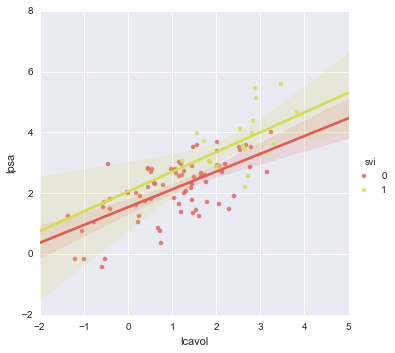

In [39]:
sns.lmplot("lcavol", "lpsa", prostate, hue="svi");

Plotting in different columns of a grid also makes a plot that's easy to understand, although direct comparisons between the subsets are more difficult as the data are separated in space. This might be better when you want the viewer to focus on the relationship within each subset independently.

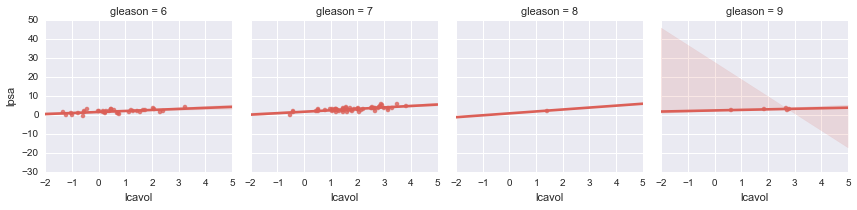

In [40]:
sns.lmplot("lcavol", "lpsa", prostate, col="gleason", size=3);

You can also assign the same variable to multiple roles. This lets you plot the data separately and use color to semantically tag different subsets of the data. Using color in this way can be helpful when you are making multiple different kind of plots, and you want to help connect them visually.

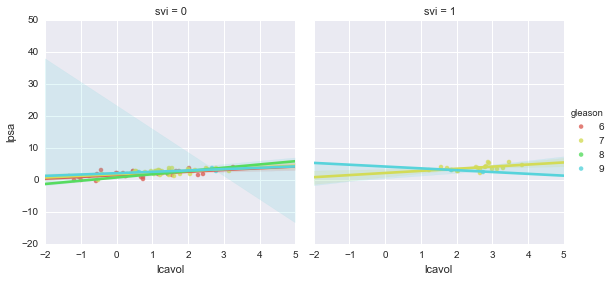

In [41]:
sns.lmplot("lcavol", "lpsa", prostate, col="svi", hue="gleason", size=4);

# Inference for multiple regression

## Regression function at one point

One thing one might want to *learn* about the regression function in
the supervisor example is something about the regression function at
some fixed values of ${X}_{1}, \dots, {X}_{6}$, i.e. what
can be said about
$$
\beta_0 + 1.3 \cdot \beta_1 + 3.6 \cdot \beta_2  + 64 \cdot \beta_3 + \\
0.1 \cdot \beta_4 + 0.2 \cdot \beta_5 - 0.2 \cdot \beta_6 + 25 \cdot \beta_7  \tag{*}$$
roughly the regression function at “typical” values of the
predictors.

The expression above is equivalent to
$$\sum_{j=0}^7 a_j \beta_j, \qquad a=(1,1.3,3.6,64,0.1,0.2,-0.2,25).$$

## Confidence interval for $\sum_{j=0}^p a_j \beta_j$

-   Suppose we want a $(1-\alpha)\cdot 100\%$ CI for
    $\sum_{j=0}^p a_j\beta_j$.

-   Just as in simple linear regression:

    $$\sum_{j=0}^p a_j \widehat{\beta}_j \pm t_{1-\alpha/2, n-p-1} \cdot SE\left(\sum_{j=0}^p a_j\widehat{\beta}_j\right).$$

`statsmodels`' will form these coefficients for each coefficient separately when using the `conf_int` function. These linear combinations are of the form
$$
a_{\tt lcavol} = (0,1,0,0,0,0,0,0)
$$
so that
$$
a_{\tt lcavol}^T\widehat{\beta} = \widehat{\beta}_1 = {\tt coef(prostate.lm)[2]}
$$

In [42]:
print res.conf_int(alpha=.1)

                  0         1
Intercept -0.957849  1.946158
lcavol     0.426855  0.712237
lweight    0.284566  0.944274
age       -0.039160 -0.002667
lbph       0.001639  0.193066
svi        0.356505  1.148289
lcp       -0.253468  0.043549
pgg45     -0.000301  0.010950



## $T$-statistics revisited

Of course, these confidence intervals are based on the standard ingredients of a
$T$-statistic.

-   Suppose we want to test $$H_0:\sum_{j=0}^p a_j\beta_j= h.$$ As in
    simple linear regression, it is based on
    $$T = \frac{\sum_{j=0}^p a_j \widehat{\beta}_j - h}{SE(\sum_{j=0}^p a_j \widehat{\beta\
}_j)}.$$

-   If $H_0$ is true, then $T \sim t_{n-p-1}$, so we reject $H_0$ at
    level $\alpha$ if $$\begin{aligned}
       |T| &\geq t_{1-\alpha/2,n-p-1}, \qquad \text{ OR} \\
       p-\text{value} &= {\tt 2*(1-pt(|T|, n-p-1))} \leq \alpha.
       \end{aligned}$$


`statsmodels` produces these in the `summary` of the linear regression model. Again, each of these 
linear combinations is a vector $a$ with only one non-zero entry like $a_{\tt lcavol}$ above.

In [43]:
print res.summary()

                            OLS Regression Results                            
Dep. Variable:                   lpsa   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     25.01
Date:                Thu, 12 Feb 2015   Prob (F-statistic):           1.54e-18
Time:                        18:08:40   Log-Likelihood:                -98.303
No. Observations:                  97   AIC:                             212.6
Df Residuals:                      89   BIC:                             233.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.4942      0.874      0.566      0.5

## Questions about many (combinations) of $\beta_j$’s

-   In multiple regression we can ask more complicated questions than in
    simple regression.

-   For instance, we could ask whether `lcp` and `pgg45` 
explains little of the variability in the data, and might be dropped
from the regression model.

-   These questions can be answered answered by $F$-statistics.

- **Note: This hypothesis should really be formed *before* looking at the output of
`summary`.**

- Later we'll see some examples of the messiness when forming a hypothesis after seeing
the `summary`...


## Dropping one or more variables

-   Suppose we wanted to test the above hypothesis
    Formally, the null hypothesis is: $$ H_0: \beta_{\tt lcp} (=\beta_6) =\beta_{\tt pgg45} (=\beta_7) =0$$
    and the alternative is
    $$
    H_a = \text{one of $ \beta_{\tt lcp},\beta_{\tt pgg45}$ is not 0}. 
    $$

-   This test is an $F$-test based on two models $$\begin{aligned}
       Full: Y_i &= \beta_0 + \sum_{j=1}^7 \beta_j X_{ij} \beta_j + \varepsilon_i \\
       Reduced: Y_i &= \beta_0 + \sum_{j=1}^5 \beta_j X_{ij} + \varepsilon_i \\
       \end{aligned}$$

-   **Note:    The reduced model $R$ must be a special case of the full model $F$
    to use the $F$-test. **


## $F$-statistic for $H_0:\beta_{\tt lcp}=\beta_{\tt pgg45}=0$

-   We compute the $F$ statistic the same to compare any models
     $$\begin{aligned}
       F &=\frac{\frac{SSE(R) - SSE(F)}{2}}{\frac{SSE(F)}{n-1-p}} \\
       & \sim F_{2, n-p-1}       \qquad   (\text{if $H_0$ is true})
       \end{aligned}$$

-   Reject $H_0$ at level $\alpha$ if $F > F_{1-\alpha, 2, n-1-p}$.


When comparing two models, one a special case of the other (i.e. 
one nested in the other), we can test if the smaller
model (the special case) is roughly as good as the 
larger model in describing our outcome. This is typically
tested using an *F* test based on comparing
the two models. We can use `anova_lm` to do this.

In [47]:
reduced_lm = smf.ols("lpsa ~ lcavol + lweight + age + lbph + svi", data=prostate).fit()
print anova_lm(reduced_lm, res)

   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0        91  44.436682        0       NaN       NaN       NaN
1        89  43.107558        2  1.329124  1.372057  0.258896
